In [6]:
"""
LSTM (Long Short-Term Memory) model for stock price prediction.

This module provides a deep learning LSTM model that can capture
complex patterns and long-term dependencies in price data.
"""

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler


class LSTMModel:
    """
    LSTM model for price prediction using deep learning.
    
    This model uses LSTM layers to capture temporal patterns in price data,
    with data normalization and dropout for better generalization.
    """
    
    def __init__(self, lag=60, epochs=50):
        """
        Initialize the LSTM model.
        
        Args:
            lag (int): Number of previous prices to use for prediction
            epochs (int): Number of training epochs
        """
        self.lag = lag
        self.epochs = epochs
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def train(self, closes):
        """
        Train LSTM on price data.
        
        Args:
            closes (np.ndarray): Array of closing prices
            
        Returns:
            float: Model confidence score based on validation loss
            
        Raises:
            ValueError: If insufficient data for training
        """
        if len(closes) < self.lag + 10:
            raise ValueError(f"Not enough data for LSTM training. Need at least {self.lag + 10} points, got {len(closes)}")
            
        # Scale data to [0, 1] range for better LSTM performance
        scaled_data = self.scaler.fit_transform(closes.reshape(-1, 1))
        
        # Prepare sequences for LSTM training
        X, y = [], []
        for i in range(self.lag, len(scaled_data)):
            X.append(scaled_data[i-self.lag:i, 0])
            y.append(scaled_data[i, 0])
            
        X = np.array(X)
        y = np.array(y)
        # Reshape for LSTM: (samples, timesteps, features)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        
        # Build LSTM model architecture
        self.model = keras.Sequential([
            layers.LSTM(50, return_sequences=True, input_shape=(self.lag, 1)),
            layers.Dropout(0.2),  # Prevent overfitting
            layers.LSTM(50, return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(25),
            layers.Dense(1)
        ])
        
        # Compile model
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train with validation split
        history = self.model.fit(
            X, y,
            batch_size=32,
            epochs=self.epochs,
            validation_split=0.2,
            verbose=0  # Suppress training output
        )
        
        # Calculate confidence from validation loss (lower is better)
        val_loss = history.history['val_loss'][-1]
        confidence = max(0.0, min(1.0, 1.0 - val_loss))
        
        return confidence
        
    def predict(self, closes, horizon):
        """
        Generate forecast using trained LSTM model.
        
        Args:
            closes (np.ndarray): Historical closing prices
            horizon (int): Number of future periods to predict
            
        Returns:
            tuple: (forecast_list, next_prediction)
                - forecast_list: List of predicted prices for all horizons
                - next_prediction: Single prediction for next period
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")
            
        # Scale the input data using the same scaler
        scaled_data = self.scaler.transform(closes.reshape(-1, 1))
        last_window = scaled_data[-self.lag:]
        
        forecast = []
        current_window = last_window.copy()
        
        # Generate recursive predictions
        for _ in range(horizon):
            # Reshape for LSTM prediction
            X_pred = np.reshape(current_window, (1, self.lag, 1))
            pred_scaled = self.model.predict(X_pred, verbose=0)[0, 0]
            
            # Inverse transform to get actual price
            pred = self.scaler.inverse_transform([[pred_scaled]])[0, 0]
            forecast.append(pred)
            
            # Update window: remove oldest, add new prediction
            current_window = np.append(current_window[1:], [[pred_scaled]], axis=0)
            
        return forecast, forecast[0]  # Return forecast and next prediction


/Users/muhammadaminesaev/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


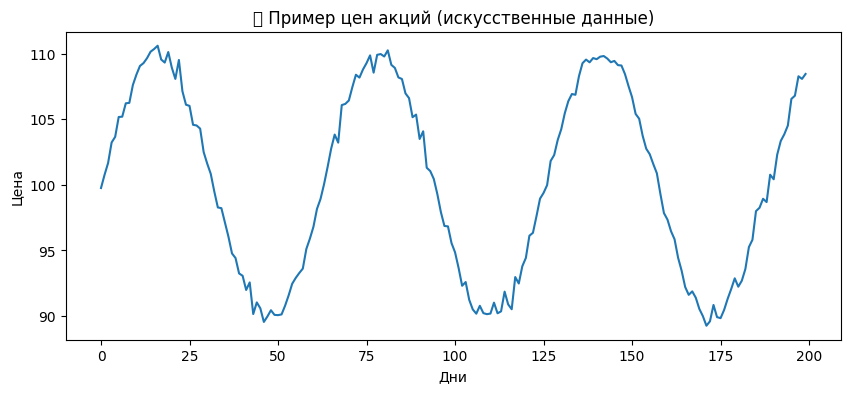

Epoch 1/10
4/4 [==============================] - 1s 95ms/step - loss: 0.4263 - val_loss: 0.1463
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1571 - val_loss: 0.0764
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1129 - val_loss: 0.0587
Epoch 4/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0749 - val_loss: 0.0559
Epoch 5/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0619 - val_loss: 0.0498
Epoch 6/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0578 - val_loss: 0.0360
Epoch 7/10
4/4 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0227
Epoch 8/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0379 - val_loss: 0.0160
Epoch 9/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0253 - val_loss: 0.0094
Epoch 10/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0146 - val_loss: 0.0038

✅ Модель обучена! Уверенност

/Users/muhammadaminesaev/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


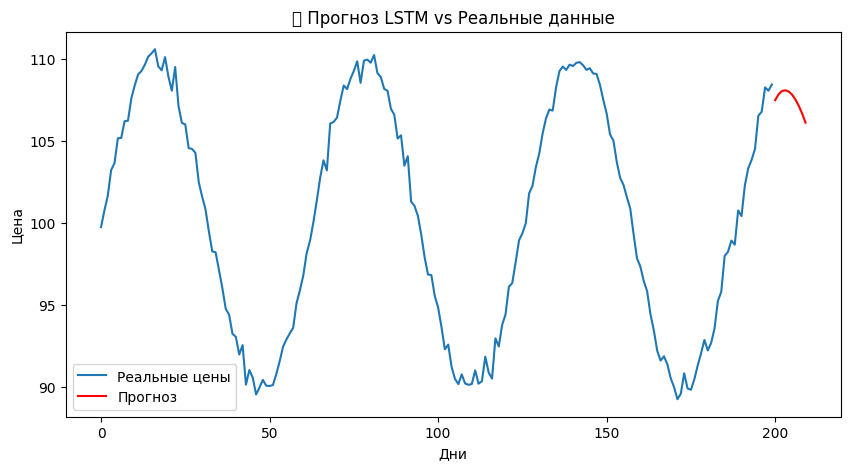

In [7]:
# 📌 Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# 🧠 Класс LSTM модели
# -----------------------------------------------------------

class LSTMModel:
    """
    LSTM модель для прогнозирования цен.
    
    Использует рекуррентные нейронные сети для анализа временных рядов.
    """
    
    def __init__(self, lag=60, epochs=50):
        """
        Инициализация модели
        
        Args:
            lag (int): сколько прошлых значений использовать для прогноза
            epochs (int): количество эпох обучения
        """
        self.lag = lag
        self.epochs = epochs
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def train(self, closes):
        """
        Обучение модели на данных о ценах.
        
        Args:
            closes (np.ndarray): массив цен закрытия
        """
        if len(closes) < self.lag + 10:
            raise ValueError(f"Недостаточно данных для обучения (нужно хотя бы {self.lag + 10} значений)")
            
        # Нормализация данных
        scaled_data = self.scaler.fit_transform(closes.reshape(-1, 1))
        
        # Подготовка последовательностей
        X, y = [], []
        for i in range(self.lag, len(scaled_data)):
            X.append(scaled_data[i-self.lag:i, 0])
            y.append(scaled_data[i, 0])
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        
        # Архитектура модели
        self.model = keras.Sequential([
            layers.LSTM(50, return_sequences=True, input_shape=(self.lag, 1)),
            layers.Dropout(0.2),
            layers.LSTM(50, return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(25),
            layers.Dense(1)
        ])
        
        # Компиляция
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Обучение модели
        history = self.model.fit(
            X, y,
            batch_size=32,
            epochs=self.epochs,
            validation_split=0.2,
            verbose=1
        )
        
        # Возврат значения ошибки
        val_loss = history.history['val_loss'][-1]
        confidence = max(0.0, min(1.0, 1.0 - val_loss))
        return confidence
        
    def predict(self, closes, horizon):
        """
        Прогнозирование будущих цен.
        
        Args:
            closes (np.ndarray): исторические цены
            horizon (int): на сколько шагов вперёд прогноз
        
        Returns:
            list: прогнозируемые цены
        """
        if self.model is None:
            raise ValueError("Модель не обучена")
            
        scaled_data = self.scaler.transform(closes.reshape(-1, 1))
        last_window = scaled_data[-self.lag:]
        
        forecast = []
        current_window = last_window.copy()
        
        for _ in range(horizon):
            X_pred = np.reshape(current_window, (1, self.lag, 1))
            pred_scaled = self.model.predict(X_pred, verbose=0)[0, 0]
            pred = self.scaler.inverse_transform([[pred_scaled]])[0, 0]
            forecast.append(pred)
            current_window = np.append(current_window[1:], [[pred_scaled]], axis=0)
            
        return forecast, forecast[0]

# -----------------------------------------------------------
# 📊 Демонстрация работы модели
# -----------------------------------------------------------

# 1️⃣ Генерация искусственных данных
days = np.arange(0, 200)
prices = np.sin(days / 10) * 10 + 100 + np.random.normal(0, 0.5, len(days))

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("📈 Пример цен акций (искусственные данные)")
plt.xlabel("Дни")
plt.ylabel("Цена")
plt.show()

# 2️⃣ Обучение модели
model = LSTMModel(lag=60, epochs=10)  # меньше эпох для демонстрации
confidence = model.train(prices)
print(f"\n✅ Модель обучена! Уверенность: {confidence:.4f}")

# 3️⃣ Прогнозирование на 10 шагов вперёд
forecast, next_pred = model.predict(prices, horizon=10)
print("\nСледующие 10 прогнозируемых цен:")
print(forecast)

# 4️⃣ Визуализация прогноза
plt.figure(figsize=(10, 5))
plt.plot(prices, label="Реальные цены")
plt.plot(range(len(prices), len(prices) + len(forecast)), forecast, label="Прогноз", color='red')
plt.title("🔮 Прогноз LSTM vs Реальные данные")
plt.xlabel("Дни")
plt.ylabel("Цена")
plt.legend()
plt.show()
